<center><img src="header.png" width="25%" style="border-radius:20px;" /></center>

# Intro

We are Gal Elharar (207906553) and Roy Wolfer (324074566), computer science students with a strong passion for data science and its applications in healthcare.  
For our semester project, we sought to tackle a meaningful challenge while expanding our skill set.  
After exploring Kaggle competitions, we were immediately drawn to the [Equity in post-HCT Survival Predictions](https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions) challenge.

This competition focuses on predicting survival probabilities for patients undergoing hematopoietic cell transplantation (HCT),  
with an emphasis on ensuring equitable outcomes across different racial groups.  
The evaluation metric used in this challenge is the Stratified Concordance Index (C-index),  
which adjusts for racial stratification to promote fairness and equity in the predictions.  
This makes the challenge particularly impactful in addressing disparities in healthcare outcomes.

We are excited to dive into this project, combining our data science skills with our interest in advancing equity in medicine.

### The problem

We couldn’t explain the problem any better as it was outlined in the kaggle challenge description:

Improving survival predictions for allogeneic HCT patients is a vital healthcare challenge.  
Current predictive models often fall short in addressing disparities related to socioeconomic status, race, and geography.  
Addressing these gaps is crucial for enhancing patient care, optimizing resource utilization, and rebuilding trust in the healthcare system.

This competition aims to encourage participants to advance predictive modeling by ensuring that survival predictions are both precise and fair for patients across diverse groups.  
By using synthetic data, which mirrors real-world situations while protecting patient privacy, participants can build and improve models that more effectively consider diverse backgrounds and conditions.

You’re challenged to develop advanced predictive models for allogeneic HCT that enhance both accuracy and fairness in survival predictions.  
The goal is to address disparities by bridging diverse data sources, refining algorithms, and reducing biases to ensure equitable outcomes for patients across diverse race groups.  
Your work will help create a more just and effective healthcare environment, ensuring every patient receives the care they deserve.

### Risk Score

In the “Equity in post-HCT Survival Predictions” challenge, survival predictions are quantified as risk scores.  
These scores represent the likelihood of an adverse event (i.e., death, relapse, rejection, or moderate to severe GVHD) occurring within a specific timeframe after hematopoietic cell transplantation (HCT).  
To evaluate the predictions, the risk scores are compared to actual survival outcomes, and their discrimination ability is assessed using the Stratified Concordance Index (C-index).

##### Key Details:

1. Risk Score Scale:
    - A higher risk score indicates a higher likelihood of the target event (e.g., shorter survival time or higher mortality risk).
    - A lower risk score suggests a lower probability of the target event (e.g., longer survival time or lower mortality risk).
2. Stratification for Fairness:
    - The risk scores are stratified across different racial groups to evaluate fairness.
    - Consistent and unbiased predictions across groups are critical for equitable healthcare applications.
3. Clinical Implications:
    - These risk scores may guide clinical decision-making by identifying patients at higher risk, enabling personalized follow-up and care.

# EDA

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
import xgboost
import catboost
import warnings
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from scipy.stats import rankdata
from itables import show
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, quantile_transform
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

all_model_scores = {}

### Reading the data

We read the data and observe:
1. The training dataset has 59 columns, many of which are categorical and have missing values.
2. Two columns are missing from the test dataset: `efs` and `efs_time`. These two columns together make up the target.

In [6]:
train = pd.read_csv('datasets/train.csv', index_col='ID')
test = pd.read_csv('datasets/test.csv', index_col='ID')
data_dictionary = pd.read_csv('datasets/data_dictionary.csv')
train.tail()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
ID,,,,,,,,,,,,,,,,,,,,,
28795,Intermediate - TED AML case <missing cytogenetics,NaN,Favorable,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,Bi-directional non-permissive,NaN,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,18.633
28796,High,No,Poor,Yes,1.0,4.0,No TBI,No,5.0,Peripheral blood,...,GvH non-permissive,Related,"N/A, Mel not given",6.0,Yes,1.0,Yes,8.0,1.0,4.892
28797,TBD cytogenetics,NaN,Poor,NaN,2.0,8.0,No TBI,NaN,6.0,Peripheral blood,...,GvH non-permissive,Unrelated,"N/A, Mel not given",8.0,NaN,2.0,No,10.0,0.0,23.157
28798,N/A - non-malignant indication,No,Poor,No,1.0,4.0,No TBI,No,3.0,Peripheral blood,...,Permissive mismatched,Related,MEL,4.0,No,1.0,No,5.0,0.0,52.351
28799,N/A - pediatric,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,Permissive mismatched,Related,MEL,8.0,No,2.0,Yes,10.0,0.0,25.158


In [7]:
features = [f for f in test.columns if f != 'ID']

race_groups = np.unique(train.race_group)


### The data dictionary

The data dictionary simply describes the 59 columns of the dataset:

In [8]:
show(data_dictionary, scrollY="400px", scrollCollapse=True, paging=False, classes="display compact", columnDefs=[{"className": "dt-left", "targets": "_all"}], layout={"topStart": "search", "topEnd": None})

### Race group distribution

In the training data, there are six race groups with about 4800 samples each.  
Because in no country of the world these six race groups occur with equal frequencies, we know that some of the groups have been upsampled or downsampled in the dataset.

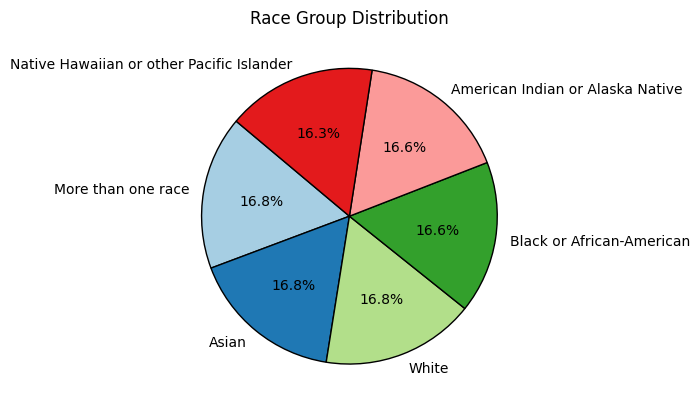

In [9]:
race_counts = train.race_group.value_counts()

plt.pie(race_counts.values, labels=race_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'})

plt.title('Race Group Distribution')
plt.show()

### Missing values

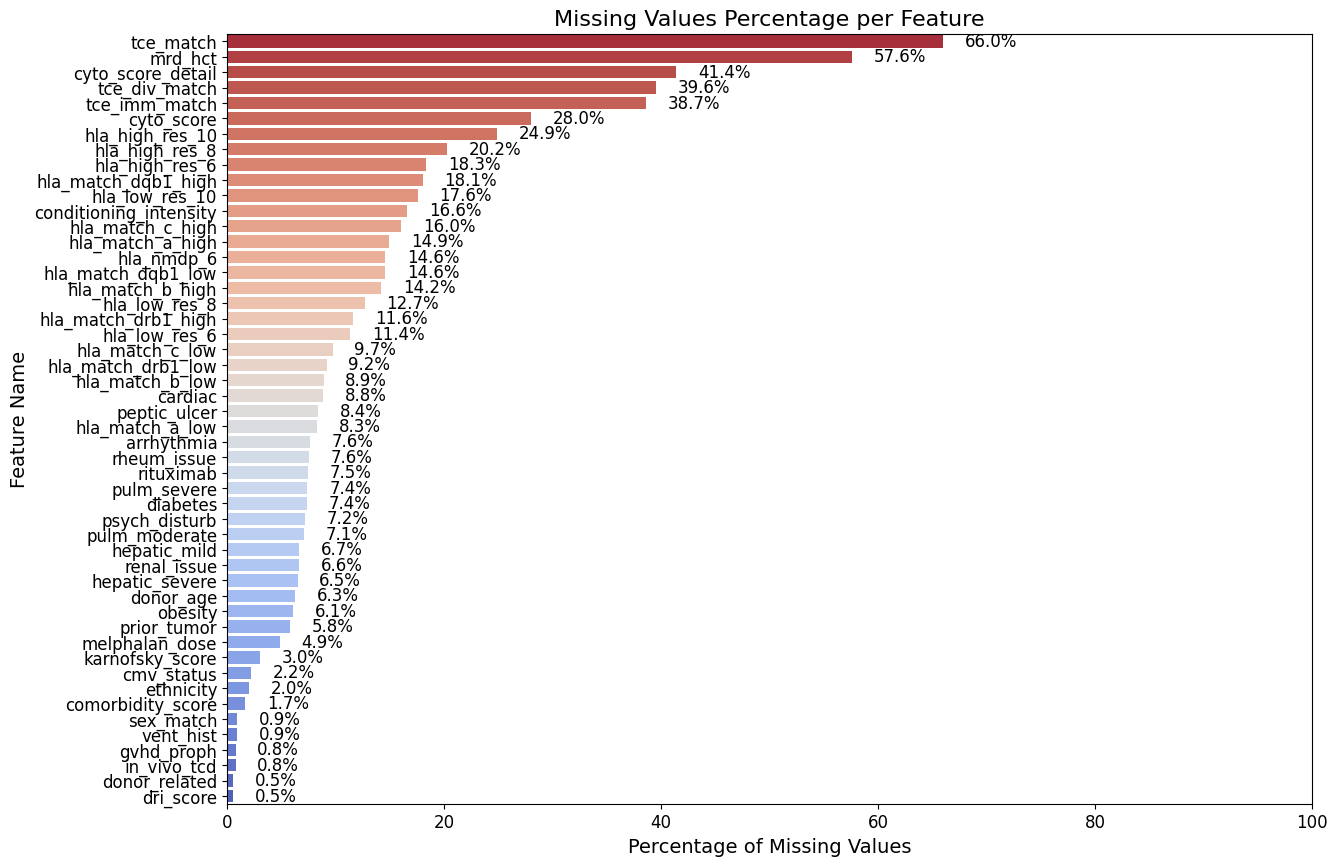

In [10]:
# Calculate missing values percentage
missing_values = train.isnull().sum() / len(train) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Generate a color gradient from dark blue (low missing) to red (high missing)
colors = sns.color_palette("coolwarm", len(missing_values))[::-1]

# Plot missing values with updated formatting
plt.figure(figsize=(14, 10))
bars = sns.barplot(y=missing_values.index, x=missing_values.values, palette=colors, hue=missing_values.index)

# Set x-axis to always go up to 100%
plt.xlim(0, 100)

# Labels and title
plt.xlabel("Percentage of Missing Values", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.title("Missing Values Percentage per Feature", fontsize=16)

# Rotate x-axis ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

# Annotate each bar with its missing percentage
for bar, value in zip(bars.patches, missing_values.values):
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
             f"{value:.1f}%", ha='left', va='center', fontsize=12, color='black')

plt.show()

Some features are incomplete. For example, we see that `tce_match` has a lot of missing values!  
*(TCE Match refers to a specific type of immune match between donors and recipients in HCT transplants)*  

What should we do?

We have three options:
1. Fill in (impute) the missing values using the mean, median, or mode.
2. Drop the feature if it’s mostly empty.
3. Treat missing values as a separate category - sometimes missing data itself carries meaning!

For now, at least for the categorical features, we choose the third option.

In [11]:
cat_features = list(train.select_dtypes(object).columns)
train[cat_features] = train[cat_features].astype(str).astype('category')

Let's review the missing values now.

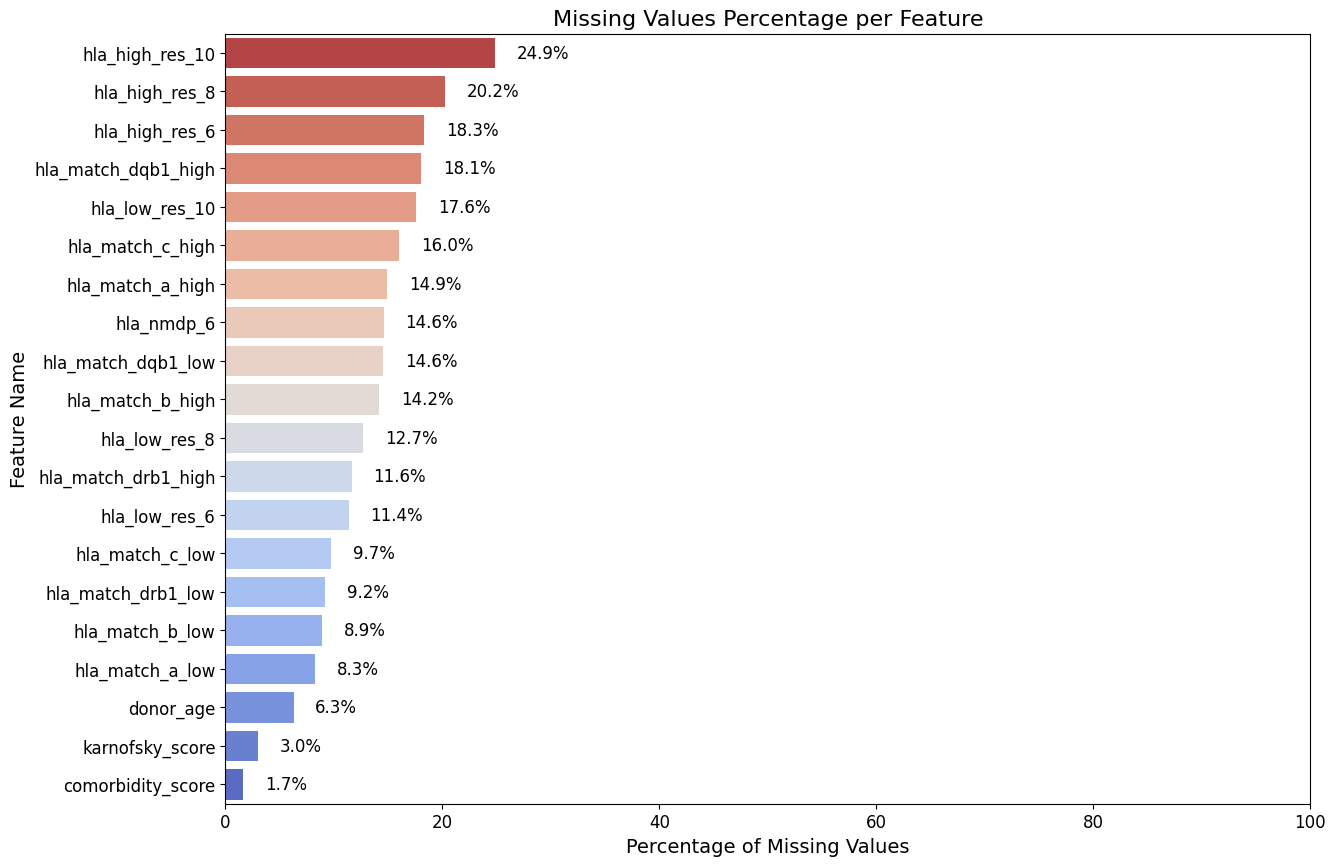

In [12]:
# Calculate missing values percentage
missing_values = train.isnull().sum() / len(train) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Generate a color gradient from dark blue (low missing) to red (high missing)
colors = sns.color_palette("coolwarm", len(missing_values))[::-1]

# Plot missing values with updated formatting
plt.figure(figsize=(14, 10))
bars = sns.barplot(y=missing_values.index, x=missing_values.values, palette=colors, hue=missing_values.index)

# Set x-axis to always go up to 100%
plt.xlim(0, 100)

# Labels and title
plt.xlabel("Percentage of Missing Values", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.title("Missing Values Percentage per Feature", fontsize=16)

# Rotate x-axis ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

# Annotate each bar with its missing percentage
for bar, value in zip(bars.patches, missing_values.values):
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
             f"{value:.1f}%", ha='left', va='center', fontsize=12, color='black')

plt.show()

Much better!  
Now our models will be able to handle missing values for categorical features.

### The weirdness of the age distribution

There are only two features with continuous data: donor age and patient age.  
The patient age histogram shows that the patient age distribution has five modes.  
Such a distribution is highly unnatural — it must be an artefact of the synthetic data generation. 

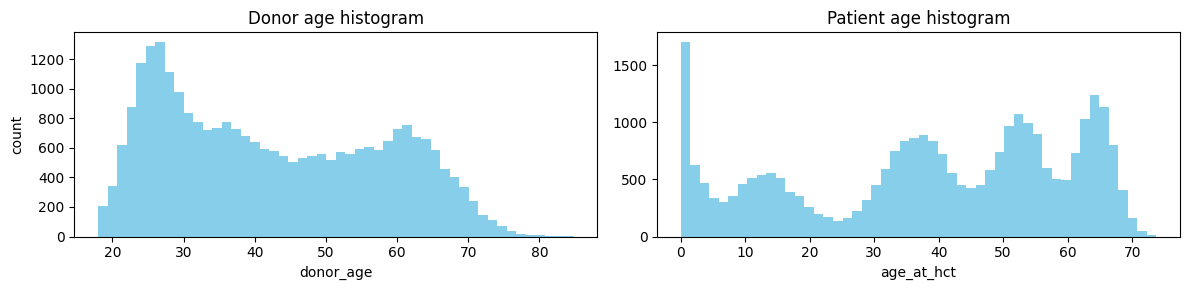

In [13]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.hist(train.donor_age, bins=50, color='skyblue')
plt.title('Donor age histogram')
plt.xlabel('donor_age')
plt.ylabel('count')
plt.subplot(1, 2, 2)
plt.title('Patient age histogram')
plt.hist(train.age_at_hct, bins=50, color='skyblue')
plt.xlabel('age_at_hct')
plt.tight_layout()
plt.show()

Our first thought was that different race groups had different modes, but the patient age distribution has the same five modes in every race group:

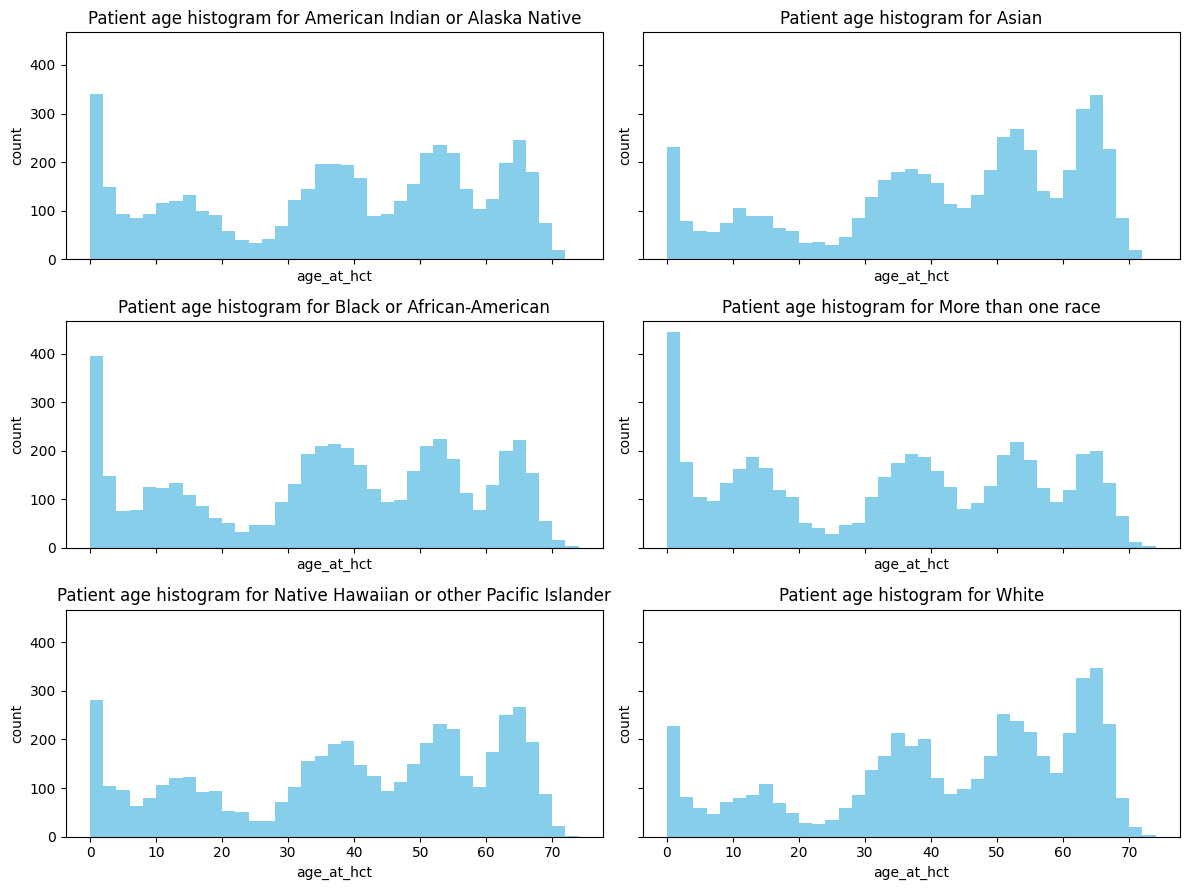

In [14]:
_, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 9))
for race_group, ax in zip(race_groups, axs.ravel()):
    ax.hist(train.age_at_hct[train.race_group == race_group],
            bins=np.linspace(0, 74, 38),
            color='skyblue')
    ax.set_title(f'Patient age histogram for {race_group}')
    ax.set_xlabel('age_at_hct')
    ax.set_ylabel('count')
plt.tight_layout()
plt.show()

Even stranger: The age of 0.044 years (i.e., 16 days) occurs 1005 times in the training dataset, whereas every other age occurs at most six times.  
Is hematopoietic cell transplantation a treatment which is often done to newborns? Possible. But we can't believe that these babies are all treated exactly when they are 16 days old. 

In [15]:
train.age_at_hct.value_counts().sort_values(ascending=False).head()

age_at_hct
0.044     1005
15.820       6
64.470       6
31.938       5
62.164       5
Name: count, dtype: int64

### The prediction target

The prediction target consists of two parts:
1. `efs_time`, always positive, is a time, measured in months.
2. `efs`, always zero or one, indicates the presence or absence of an event:
   - `efs=1` means "patient was without event for **exactly** `efs_time`.
   - `efs=0` means "patient was without event for **at least** `efs_time`"

This situation is called "censored data": Samples of which we know the time of event are uncensored, and if we only know a lower bound for the time of event, the sample is (right-)censored.

**Censoring is the main reason that this competition has a special metric and that we need special models.**  
The competition is a regression task, but we know y_true for only half the samples.  
For the other (censored) half, all we know is lower bounds for y_true.  
One cannot compute a squared error based on `y_true > 100 and y_pred == 120`. RMSE and similar metrics cannot deal with that.

Weird thing to note, `efs_time` is a float with three digits after the decimal point.  
Even though it is measured in months, the recorded numbers don't really align to days for any month.  
We doubt that possible events of a patient are recorded with a more exact unit than a day.  
So this might also be a case caused by the synthetic data generation.

A histogram of the target values shows that half the patients have an event within 20 months after the transplantation.  
The other half, without event for the first 20 months, has a high probability of not having an event for much longer.

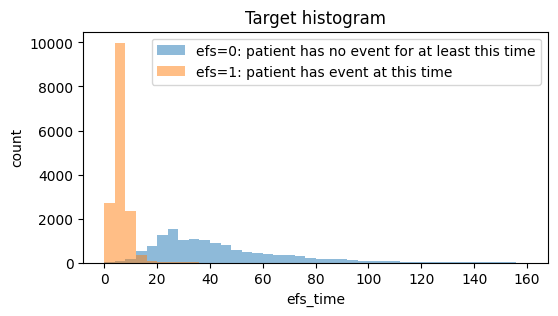

In [16]:
plt.figure(figsize=(6, 3))
plt.hist(train.efs_time[train.efs == 0], bins=np.linspace(0, 160, 41), label='efs=0: patient has no event for at least this time', alpha=0.5)
plt.hist(train.efs_time[train.efs == 1], bins=np.linspace(0, 160, 41), label='efs=1: patient has event at this time', alpha=0.5)
plt.legend()
plt.xlabel('efs_time')
plt.ylabel('count')
plt.title('Target histogram')
plt.show()

### Survival function and cumulative hazard function

The survival function shows how many patients have no event for an amount of time ([Kaplan–Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator)).  
At month 0, 100% of the patients have no event. At month 20, only 40% - 60% remain without event, depending on their race group.  
Patients with "more than one race" have the highest probability of event-free survival, while whites have the lowest.

The cumulative hazard is another representation of the same facts, it corresponds to the negative logarithm of the survival function ([Nelson–Aalen estimator](https://en.wikipedia.org/wiki/Nelson%E2%80%93Aalen_estimator)).

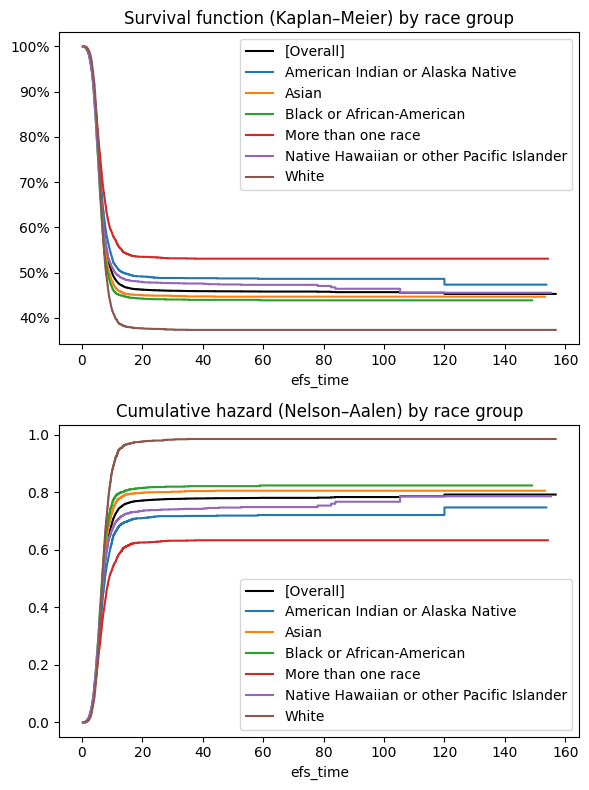

In [17]:
def survival_function(df):
    survival_df = df[['efs', 'efs_time']].groupby('efs_time').agg(['size', 'sum']).droplevel(0, axis=1).astype(int)
    survival_df['n_at_risk'] = survival_df['size'].sum() - survival_df['size'].shift().fillna(0).cumsum().astype(int)
    hazard = survival_df['sum'] / survival_df['n_at_risk'] 
    survival_df['cumulative_hazard'] = np.cumsum(hazard) # nelson_aalen_estimator
    survival_df['survival_probability'] = (1 - hazard).cumprod() # kaplan_meier_estimator
    return survival_df

plt.figure(figsize=(6, 8))

plt.subplot(2, 1, 1)
survival_df = survival_function(train)
plt.step(survival_df.index, survival_df['survival_probability'], c='k', where="post", label='[Overall]')
plt.xlabel('efs_time')
for race_group in race_groups:
    subset = train.query('race_group == @race_group')
    survival_df = survival_function(subset)
    plt.step(survival_df.index, survival_df['survival_probability'], where="post", label=race_group)
plt.xlabel('efs_time')
plt.legend(loc='upper right')
plt.title('Survival function (Kaplan–Meier) by race group')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0)) # percent of xmax

plt.subplot(2, 1, 2)
survival_df = survival_function(train)
plt.step(survival_df.index, survival_df['cumulative_hazard'], c='k', where="post", label='[Overall]')
plt.xlabel('efs_time')
for race_group in race_groups:
    subset = train.query('race_group == @race_group')
    survival_df = survival_function(subset)
    plt.step(survival_df.index, survival_df['cumulative_hazard'], where="post", label=race_group)
plt.xlabel('efs_time')
plt.legend(loc='lower right')
plt.title('Cumulative hazard (Nelson–Aalen) by race group')

plt.tight_layout()
plt.show()


### Is the Difference in Survival Significant?  
So far, we've seen that survival probabilities **vary by race group**, but are these differences **statistically significant**?  
To answer this, we'll use the **Log-Rank Test**, a statistical test designed to compare survival distributions between groups.  

If the p-value is **less than 0.05**, it means the difference is **statistically significant**—one group truly has a better survival outcome than the other. If not, any differences we see could be due to chance.

In [18]:
from lifelines.statistics import logrank_test

# Select two race groups for comparison
race_group_1 = train[train["race_group"] == "White"]
race_group_2 = train[train["race_group"] == "More than one race"]

# Perform Log-Rank Test
log_rank_result = logrank_test(
    race_group_1["efs_time"], race_group_2["efs_time"],
    event_observed_A=race_group_1["efs"],
    event_observed_B=race_group_2["efs"]
)

# Print p-value to check statistical significance
print(f"Log-Rank Test p-value: {log_rank_result.p_value}")

# Interpretation of results
if log_rank_result.p_value < 0.05:
    print("✅ Significant survival difference! One race group has a statistically different survival rate.")
else:
    print("❌ No significant difference in survival between these race groups.")

Log-Rank Test p-value: 1.7979929627739182e-49
✅ Significant survival difference! One race group has a statistically different survival rate.


### Feature correlation
Sometimes, two features are so similar that they provide the same information.  
If this happens, we might remove one to make our model simpler.

Let's explore the relationships between numerical features.  
Correlations can help us identify redundant features, where one variable provides almost the same information as another.  
High correlation (close to 1 or -1) means we might consider removing one of the features to avoid redundancy.

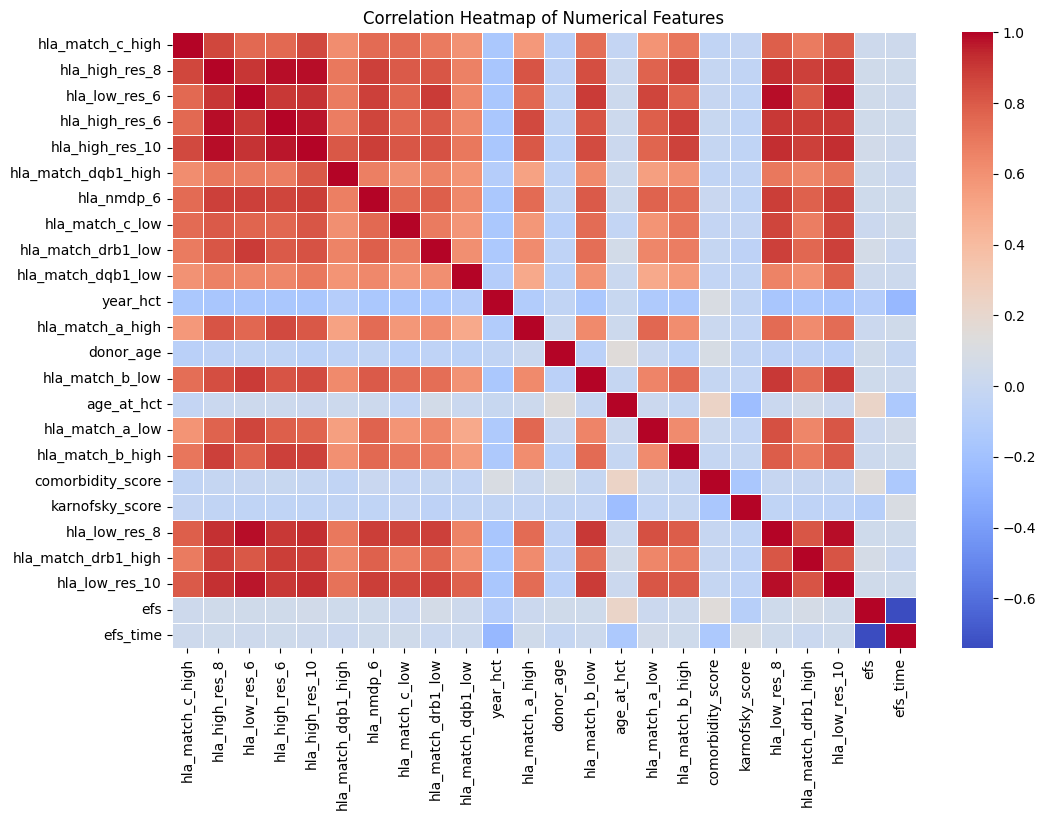

In [19]:
# Generate a correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = train.corr(numeric_only=True) # Only numerical columns
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

1. 	Some features have a very high correlation:  
	Many HLA match features (`hla_match_*`, `hla_high_res_*`) are strongly correlated.  
	This makes sense! They’re all measuring similar compatibility factors between donors and patients.  
	Do we really need all of them? Maybe not! We might remove some duplicates to keep things simple.

2. 	Survival time (`efs_time`) seems Hard to predict:  
	`efs_time` doesn’t have strong correlations with most features.  
	This tells us that survival time depends on many small factors rather than one big predictor.

3.  Age and donor age:  
	Patients (`age_at_hct`) and their donors (`donor_age`) show some relationship, but it's not very strong.

4. 	Health scores:  
	Comorbidity score and Karnofsky score have some level of correlation with each other.  
	This makes sense! A patient with more health issues (high comorbidity) probably has a lower Karnofsky score (worse physical condition).

# Evaluation
This competition is about equity in the predictions. This means that we score the predictions per race group and then derive the final score from these six sub-scores.  
As the official implementation of the competition metric doesn't output the scores per race group, we've written our own implementation, which gives more transparency.

We also show the scores recieved for each fold in the cross validation.
The overall score is the mean of all of the fold's scores.

In [20]:
kf = StratifiedKFold(n_splits=5 ,shuffle=True, random_state=1)
all_scores = {}
X_va = {}
idx_va = {}

def evaluate_fold(y_va_pred, fold):
    """Compute and print the metrics (concordance index) per race group for a single fold.

    Global variables:
    - train, X_va, idx_va
    - The metrics are saved in the global list all_scores.
    """
    metric_list = []
    for race in race_groups:
        mask = X_va.race_group.values == race
        c_index_race = concordance_index(
            train.efs_time.iloc[idx_va][mask],
            - y_va_pred[mask],
            train.efs.iloc[idx_va][mask]
        )
        # print(f"# {race:42} {c_index_race:.3f}")
        metric_list.append(c_index_race)
    fold_score = np.mean(metric_list) - np.sqrt(np.var(metric_list))
    print(f"# Total fold {fold}:{' ':29} {fold_score:.3f} mean={np.mean(metric_list):.3f} std={np.std(metric_list):.3f}")
    all_scores.append(metric_list)

def display_overall(label):
    """Compute and print the overall metrics (concordance index)"""
    df = pd.DataFrame(all_scores, columns=race_groups)
    df['mean'] = df[race_groups].mean(axis=1)
    df['std'] = np.std(df[race_groups], axis=1)
    df['score'] = df['mean'] - df['std']
    df = df.T
    df['Overall'] = df.mean(axis=1)
    temp = df.drop(index=['std']).values
    print(f"# Overall:                                   {df.loc['score', 'Overall']:.3f} {label}")
    all_model_scores[label] = df.loc['score', 'Overall']
    display(df
            .iloc[:len(race_groups)]
            .style
            .format(precision=3)
            .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
            .concat(df.iloc[len(race_groups):].style.format(precision=3))
           )
    

# Cox proportional hazards model
One method for survival analysis, is the [Cox proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model).  
Which is implemented in XGBoost and in CatBoost.

Let's try the first method.

### XGBoost Cox proportional hazards model
Cox proportional hazards model with XGBoost.  
This model expects that the two target columns be combined into one (`y = np.where(train.efs == 1, train.efs_time, -train.efs_time)`, negative target values are considered right censored)

In [21]:
# %%time
y = np.where(train.efs == 1, train.efs_time, -train.efs_time)
all_scores = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.race_group)):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = y[idx_tr]
    
    xgb_cox_params = {'objective': 'survival:cox', 'grow_policy': 'depthwise', 
                      'n_estimators': 700, 'learning_rate': 0.0254, 'max_depth': 8, 
                      'reg_lambda': 0.116, 'reg_alpha': 0.139, 'min_child_weight': 23.8,
                      'colsample_bytree': 0.59, 'subsample': 0.7, 'tree_method': 'hist',
                      'enable_categorical': True}
    model = xgboost.XGBRegressor(**xgb_cox_params)
    model.fit(X_tr, y_tr) # negative values are considered right censored
    y_va_pred = model.predict(X_va) # predicts hazard factor
    evaluate_fold(y_va_pred, fold)
display_overall('Cox Proportional Hazards XGBoost')

# Total fold 0:                              0.665 mean=0.682 std=0.017
# Total fold 1:                              0.666 mean=0.680 std=0.014
# Total fold 2:                              0.669 mean=0.680 std=0.012
# Total fold 3:                              0.674 mean=0.682 std=0.008
# Total fold 4:                              0.674 mean=0.687 std=0.013
# Overall:                                   0.669 Cox Proportional Hazards XGBoost


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.690,0.697,0.700,0.678,0.689,0.691
Asian,0.701,0.693,0.688,0.690,0.710,0.696
Black or African-American,0.681,0.661,0.670,0.696,0.668,0.675
More than one race,0.696,0.687,0.685,0.672,0.690,0.686
Native Hawaiian or other Pacific Islander,0.670,0.678,0.668,0.677,0.684,0.675
White,0.652,0.662,0.671,0.680,0.678,0.669
mean,0.682,0.680,0.680,0.682,0.687,0.682
std,0.017,0.014,0.012,0.008,0.013,0.013
score,0.665,0.666,0.669,0.674,0.674,0.669


### Catboost Cox proportional hazards model
Cox proportional hazards model with CatBoost.  
This model expects the targets in the same format as the XGBoost Cox model.

In [22]:
# %%time
y = np.where(train.efs == 1, train.efs_time, -train.efs_time)
all_scores = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.race_group)):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = y[idx_tr]
    
    cb_cox_params = {'loss_function': 'Cox', 'grow_policy': 'SymmetricTree',
                     'n_estimators': 800, 'learning_rate': 0.092, 'l2_leaf_reg': 2.5,
                     'max_depth': 7, 'colsample_bylevel': 0.84, 'subsample': 0.9, 
                     'random_strength': 0.8, 'verbose': False}
    
    model = catboost.CatBoostRegressor(**cb_cox_params, cat_features=cat_features)
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va) # predicts log of hazard factor
    evaluate_fold(y_va_pred, fold)
display_overall('Cox Proportional Hazards CatBoost')

# Total fold 0:                              0.664 mean=0.680 std=0.017
# Total fold 1:                              0.668 mean=0.683 std=0.015
# Total fold 2:                              0.670 mean=0.680 std=0.010
# Total fold 3:                              0.672 mean=0.681 std=0.009
# Total fold 4:                              0.674 mean=0.686 std=0.012
# Overall:                                   0.670 Cox Proportional Hazards CatBoost


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.688,0.701,0.699,0.675,0.691,0.691
Asian,0.707,0.697,0.685,0.695,0.706,0.698
Black or African-American,0.674,0.664,0.672,0.691,0.672,0.675
More than one race,0.690,0.689,0.680,0.677,0.685,0.684
Native Hawaiian or other Pacific Islander,0.668,0.687,0.670,0.674,0.693,0.678
White,0.655,0.661,0.674,0.674,0.671,0.667
mean,0.680,0.683,0.680,0.681,0.686,0.682
std,0.017,0.015,0.010,0.009,0.012,0.013
score,0.664,0.668,0.670,0.672,0.674,0.670


# Accelerated failure time model
Another method for survival analysis, is the [Accelerated failure time model](https://en.wikipedia.org/wiki/Accelerated_failure_time_model).  
Which is also implemented in XGBoost and in CatBoost.

We shall try it too.

### XGBoost Accelerated failure time model
Accelerated failure time model with XGBoost.  
This model expects the lower and upper bounds for the target in a special form in a DMatrix.

In [23]:
# %%time
all_scores = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.race_group)):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    d_tr = xgboost.DMatrix(X_tr, enable_categorical=True)
    d_tr.set_float_info('label_lower_bound', train.efs_time.iloc[idx_tr])
    d_tr.set_float_info('label_upper_bound', np.where(train.efs.iloc[idx_tr] == 0, np.inf, train.efs_time.iloc[idx_tr]))
    d_va = xgboost.DMatrix(X_va, enable_categorical=True)
    d_va.set_float_info('label_lower_bound', train.efs_time.iloc[idx_va])
    d_va.set_float_info('label_upper_bound', np.where(train.efs.iloc[idx_va] == 0, np.inf, train.efs_time.iloc[idx_va]))
    xgboost_aft_params = {'learning_rate': 0.08, 'max_depth': 4, 'reg_lambda': 3, 'aft_loss_distribution_scale': 0.9,
                          'reg_alpha': 0.24, 'gamma': 0.033, 'min_child_weight': 82.58861553592878,
                          'colsample_bytree': 0.5662198438953138, 'max_bin': 53, 'subsample': 0.7456329821182728, 
                          'objective': 'survival:aft', 'grow_policy': 'depthwise', 'tree_method': 'hist',
                          'aft_loss_distribution': 'normal'}
    bst = xgboost.train(xgboost_aft_params,
                        d_tr,
                        num_boost_round=300,
                       )
    y_va_pred = - bst.predict(d_va) # model predicts time of event
    evaluate_fold(y_va_pred, fold)
display_overall('Accelerated Failure Time XGBoost')

# Total fold 0:                              0.657 mean=0.676 std=0.019
# Total fold 1:                              0.659 mean=0.676 std=0.017
# Total fold 2:                              0.666 mean=0.676 std=0.009
# Total fold 3:                              0.668 mean=0.674 std=0.006
# Total fold 4:                              0.673 mean=0.684 std=0.011
# Overall:                                   0.665 Accelerated Failure Time XGBoost


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.681,0.697,0.691,0.672,0.686,0.685
Asian,0.703,0.691,0.682,0.682,0.702,0.692
Black or African-American,0.678,0.649,0.666,0.682,0.668,0.669
More than one race,0.692,0.680,0.681,0.669,0.683,0.681
Native Hawaiian or other Pacific Islander,0.660,0.677,0.667,0.667,0.688,0.672
White,0.644,0.660,0.668,0.672,0.675,0.664
mean,0.676,0.676,0.676,0.674,0.684,0.677
std,0.019,0.017,0.009,0.006,0.011,0.012
score,0.657,0.659,0.666,0.668,0.673,0.665


### CatBoost Accelerated failure time model
Accelerated failure time model with CatBoost.  
This model expects the lower and upper bounds for the target in the form of a two-column array.

In [24]:
# %%time
y = np.column_stack([train.efs_time,
                     np.where(train.efs == 1, train.efs_time, -1)])
all_scores = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.race_group)):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = y[idx_tr]
    cb_aft_params = {'loss_function': 'SurvivalAft', 'grow_policy': 'SymmetricTree', 
                     'n_estimators': 800, 'learning_rate': 0.066, 'l2_leaf_reg': 4.4,
                     'max_depth': 5, 'colsample_bylevel': 0.776, 'random_strength': 0.9, 
                     'verbose': False}
    model = catboost.CatBoostRegressor(**cb_aft_params, cat_features=cat_features)
    model.fit(X_tr, y_tr)
    y_va_pred = - model.predict(X_va) # model predicts log of time of event
    evaluate_fold(y_va_pred, fold)
display_overall('Accelerated Failure Time CatBoost')

# Total fold 0:                              0.662 mean=0.679 std=0.017
# Total fold 1:                              0.658 mean=0.676 std=0.018
# Total fold 2:                              0.664 mean=0.674 std=0.010
# Total fold 3:                              0.665 mean=0.673 std=0.007
# Total fold 4:                              0.671 mean=0.682 std=0.011
# Overall:                                   0.664 Accelerated Failure Time CatBoost


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.688,0.698,0.688,0.676,0.684,0.687
Asian,0.699,0.692,0.682,0.685,0.699,0.691
Black or African-American,0.676,0.651,0.663,0.676,0.665,0.666
More than one race,0.693,0.679,0.681,0.673,0.681,0.681
Native Hawaiian or other Pacific Islander,0.664,0.680,0.662,0.667,0.691,0.673
White,0.651,0.654,0.669,0.661,0.673,0.662
mean,0.679,0.676,0.674,0.673,0.682,0.677
std,0.017,0.018,0.010,0.007,0.011,0.013
score,0.662,0.658,0.664,0.665,0.671,0.664


# Target transformation models and regression with mean squared error

The competition task can be interpreted as predicting the order of events for the patients.  
Who has an event first? Who second? ... Who has an event last? and who survives without an event at all?  
With a suitable target transformation, we can apply the usual regression algorithms which optimize MSE or similar metrics.

### Target transformations
As we saw in the EDA, patients with a known event, mostly have an `efs_time` between 0 and 15, whereas most unkowns have an `efs_time` between 15 and 160.  
This distribution is problematic for regression models.  
We want predictions to have high discriminative power for the patients who have a known event, but we don't need to distinguish between unkowns.  
We can achieve this result by stretching the range of the patients with a known event and compressing the range of the unkowns.

Let's create such a transformation to use for our model:  

In [25]:
def transform_survival_probability(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times"""
    kmf = KaplanMeierFitter()
    kmf.fit(time, event)
    return kmf.survival_function_at_times(time).values

The next diagram shows how a typical target transformation stretches and compresses the ranges.  
We use the transformation above as the example:

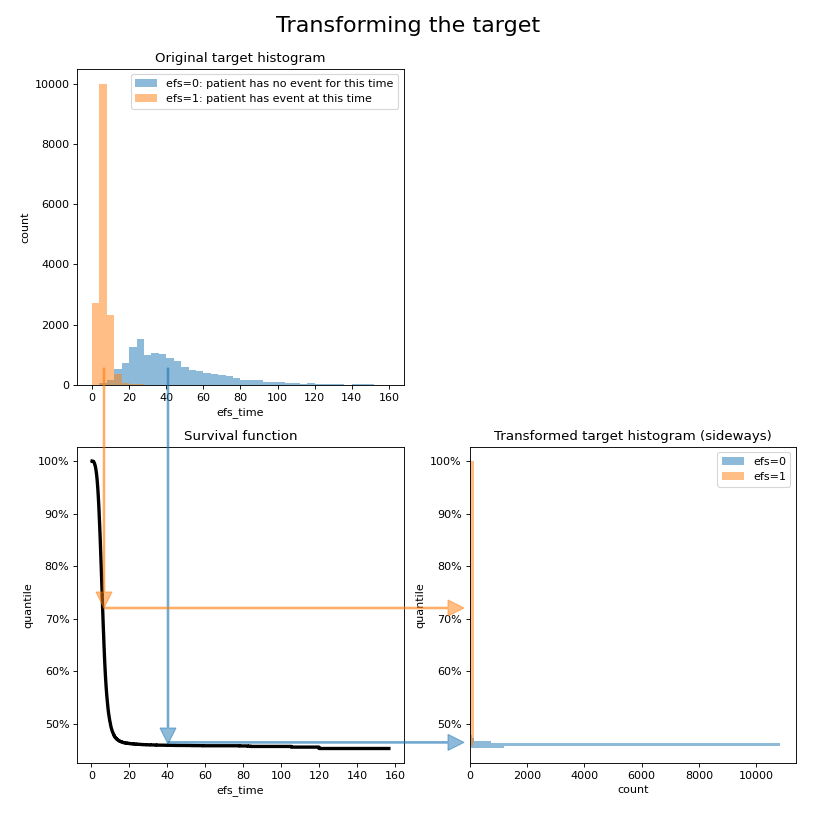

In [26]:
y_quantile = transform_survival_probability(time=train.efs_time, event=train.efs)
survival_df = survival_function(train)

fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=80)

axs[0, 0].hist(train.efs_time[train.efs == 0], bins=np.linspace(0, 160, 41), label='efs=0: patient has no event for this time', alpha=0.5)
axs[0, 0].hist(train.efs_time[train.efs == 1], bins=np.linspace(0, 160, 41), label='efs=1: patient has event at this time', alpha=0.5)
axs[0, 0].legend()
axs[0, 0].set_xlabel('efs_time')
axs[0, 0].set_ylabel('count')
axs[0, 0].set_title('Original target histogram')

axs[0, 1].set_axis_off()

axs[1, 0].step(survival_df.index, survival_df['survival_probability'], c='k', lw=3, where="post", label='[Overall]')
axs[1, 0].set_xlabel('efs_time')
axs[1, 0].set_ylabel("quantile")
axs[1, 0].set_title("Survival function")
axs[1, 0].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

axs[1, 1].hist(y_quantile[train.efs==0], bins=100, label="efs=0", orientation=u'horizontal', alpha=0.5)
axs[1, 1].hist(y_quantile[train.efs==1], bins=100, label="efs=1", orientation=u'horizontal', alpha=0.5)
axs[1, 1].legend()
axs[1, 1].set_ylabel("quantile")
axs[1, 1].set_xlabel("count")
axs[1, 1].set_title("Transformed target histogram (sideways)")
axs[1, 1].yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.add_axes(ax)
ax.arrow(0.2, 0.55, 0, -0.47, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(0), alpha=0.5, head_width=0.02, head_length=0.02)
ax.arrow(0.2, 0.082, 0.37, 0, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(0), alpha=0.5, head_width=0.02, head_length=0.02)
ax.arrow(0.12, 0.55, 0, -0.3, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(1), alpha=0.5, head_width=0.02, head_length=0.02)
ax.arrow(0.12, 0.25, 0.45, 0, length_includes_head=True, width=0.002, color=plt.get_cmap('tab10')(1), alpha=0.5, head_width=0.02, head_length=0.02)

plt.suptitle('Transforming the target', y=0.99, size=20)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.tight_layout()
plt.show()

We will add 4 more possible target transformations to test:

In [27]:
def transform_partial_hazard(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times"""
    data = pd.DataFrame({'efs_time': time, 'efs': event, 'time': time, 'event': event})
    cph = CoxPHFitter()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cph.fit(data, duration_col='time', event_col='event')
    return cph.predict_partial_hazard(data)

def transform_separate(time, event):
    """Transform the target by separating events from non-events"""
    transformed = time.values.copy()
    mx = transformed[event == 1].max() # last patient that has a known event
    mn = transformed[event == 0].min() # first patient that does not have a known event
    transformed[event == 0] = time[event == 0] + mx - mn
    transformed = rankdata(transformed)
    transformed[event == 0] += len(transformed) // 2
    transformed = transformed / transformed.max()
    return - transformed

def transform_rank_log(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times"""
    transformed = time.values.copy()
    mx = transformed[event == 1].max() # last patient that has a known event
    mn = transformed[event == 0].min() # first patient that does not have a known event
    transformed[event == 0] = time[event == 0] + mx - mn
    transformed = rankdata(transformed)
    transformed[event == 0] += len(transformed) * 2
    transformed = transformed / transformed.max()
    transformed = np.log(transformed)
    return - transformed

def transform_quantile(time, event):
    """Transform the target by stretching the range of eventful efs_times and compressing the range of event_free efs_times"""
    transformed = np.full(len(time), np.nan)
    transformed_with_event = quantile_transform(- time[event == 1].values.reshape(-1, 1)).ravel()
    transformed[event == 1] = transformed_with_event
    transformed[event == 0] = transformed_with_event.min() - 0.3
    return transformed


### XGBoost MSE loss with five different target transformations
We now plot the histograms of the five possible transformations we have created, and then fit regression models with MSE loss to each of the transformed targets.

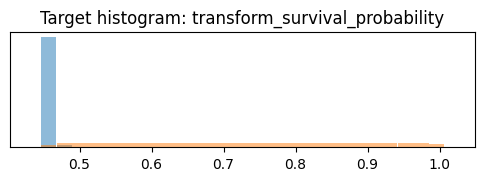

transform_survival_probability
# Total fold 0:                              0.667 mean=0.680 std=0.013
# Total fold 1:                              0.666 mean=0.676 std=0.010
# Total fold 2:                              0.669 mean=0.679 std=0.010
# Total fold 3:                              0.671 mean=0.681 std=0.010
# Total fold 4:                              0.676 mean=0.685 std=0.008
# Overall:                                   0.670 transform_survival_probability XGBoost (MSE)


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.680,0.684,0.692,0.673,0.684,0.683
Asian,0.702,0.686,0.690,0.692,0.700,0.694
Black or African-American,0.686,0.661,0.664,0.696,0.672,0.676
More than one race,0.684,0.685,0.682,0.670,0.680,0.680
Native Hawaiian or other Pacific Islander,0.659,0.674,0.673,0.671,0.684,0.672
White,0.671,0.665,0.675,0.683,0.688,0.676
mean,0.680,0.676,0.679,0.681,0.685,0.680
std,0.013,0.010,0.010,0.010,0.008,0.010
score,0.667,0.666,0.669,0.671,0.676,0.670


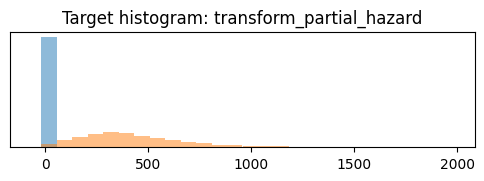

transform_partial_hazard
# Total fold 0:                              0.665 mean=0.678 std=0.013
# Total fold 1:                              0.663 mean=0.673 std=0.010
# Total fold 2:                              0.668 mean=0.679 std=0.010
# Total fold 3:                              0.671 mean=0.682 std=0.011
# Total fold 4:                              0.675 mean=0.684 std=0.009
# Overall:                                   0.669 transform_partial_hazard XGBoost (MSE)


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.675,0.684,0.694,0.675,0.683,0.682
Asian,0.701,0.682,0.688,0.698,0.701,0.694
Black or African-American,0.686,0.661,0.662,0.694,0.672,0.675
More than one race,0.683,0.682,0.681,0.672,0.682,0.680
Native Hawaiian or other Pacific Islander,0.659,0.669,0.675,0.670,0.682,0.671
White,0.668,0.661,0.673,0.683,0.685,0.674
mean,0.678,0.673,0.679,0.682,0.684,0.679
std,0.013,0.010,0.010,0.011,0.009,0.011
score,0.665,0.663,0.668,0.671,0.675,0.669


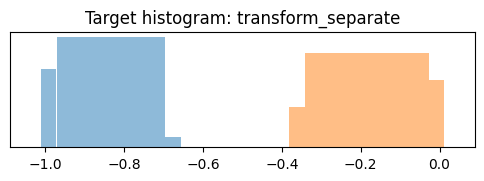

transform_separate
# Total fold 0:                              0.659 mean=0.678 std=0.019
# Total fold 1:                              0.659 mean=0.678 std=0.018
# Total fold 2:                              0.668 mean=0.678 std=0.010
# Total fold 3:                              0.671 mean=0.678 std=0.007
# Total fold 4:                              0.672 mean=0.683 std=0.011
# Overall:                                   0.666 transform_separate XGBoost (MSE)


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.685,0.698,0.690,0.678,0.687,0.687
Asian,0.703,0.693,0.689,0.688,0.703,0.695
Black or African-American,0.678,0.647,0.665,0.684,0.667,0.668
More than one race,0.691,0.686,0.683,0.675,0.681,0.683
Native Hawaiian or other Pacific Islander,0.664,0.684,0.668,0.671,0.686,0.675
White,0.645,0.659,0.671,0.670,0.675,0.664
mean,0.678,0.678,0.678,0.678,0.683,0.679
std,0.019,0.018,0.010,0.007,0.011,0.013
score,0.659,0.659,0.668,0.671,0.672,0.666


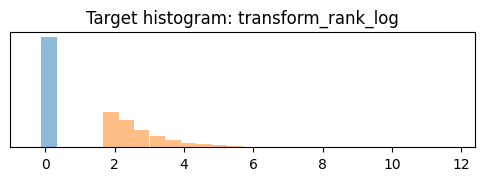

transform_rank_log
# Total fold 0:                              0.667 mean=0.683 std=0.016
# Total fold 1:                              0.666 mean=0.680 std=0.014
# Total fold 2:                              0.673 mean=0.683 std=0.011
# Total fold 3:                              0.677 mean=0.686 std=0.009
# Total fold 4:                              0.677 mean=0.688 std=0.010
# Overall:                                   0.672 transform_rank_log XGBoost (MSE)


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.685,0.696,0.699,0.681,0.690,0.690
Asian,0.706,0.689,0.691,0.704,0.708,0.699
Black or African-American,0.687,0.664,0.667,0.693,0.675,0.677
More than one race,0.693,0.691,0.688,0.680,0.685,0.687
Native Hawaiian or other Pacific Islander,0.669,0.679,0.678,0.676,0.686,0.678
White,0.657,0.659,0.676,0.683,0.681,0.671
mean,0.683,0.680,0.683,0.686,0.688,0.684
std,0.016,0.014,0.011,0.009,0.010,0.012
score,0.667,0.666,0.673,0.677,0.677,0.672


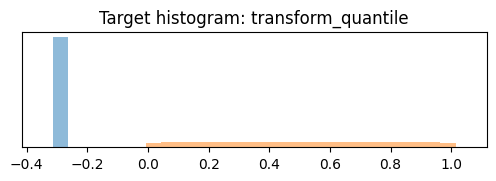

transform_quantile
# Total fold 0:                              0.670 mean=0.686 std=0.016
# Total fold 1:                              0.669 mean=0.682 std=0.013
# Total fold 2:                              0.674 mean=0.685 std=0.011
# Total fold 3:                              0.679 mean=0.687 std=0.009
# Total fold 4:                              0.680 mean=0.690 std=0.009
# Overall:                                   0.674 transform_quantile XGBoost (MSE)


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.691,0.695,0.700,0.684,0.693,0.693
Asian,0.710,0.691,0.695,0.700,0.705,0.700
Black or African-American,0.688,0.663,0.670,0.697,0.675,0.679
More than one race,0.694,0.693,0.691,0.679,0.687,0.689
Native Hawaiian or other Pacific Islander,0.670,0.685,0.676,0.677,0.690,0.680
White,0.662,0.664,0.677,0.687,0.687,0.676
mean,0.686,0.682,0.685,0.687,0.690,0.686
std,0.016,0.013,0.011,0.009,0.009,0.011
score,0.670,0.669,0.674,0.679,0.680,0.674


In [28]:
for transformation in [transform_survival_probability,
                       transform_partial_hazard,
                       transform_separate,
                       transform_rank_log,
                       transform_quantile,
                      ]:
    plt.figure(figsize=(6, 1.5))
    target = transformation(time=train.efs_time, event=train.efs)
    vmin, vmax = 1.09 * target.min() - 0.09 * target.max(), 1.09 * target.max() - 0.09 * target.min()
    plt.hist(target[train.efs == 0], bins=np.linspace(vmin, vmax, 31), density=True, label='efs=0: patient has no event for this time', alpha=0.5)
    plt.hist(target[train.efs == 1], bins=np.linspace(vmin, vmax, 31), density=True, label='efs=1: patient has event at this time', alpha=0.5)
    plt.xlim(vmin, vmax)
    plt.yticks([])
    plt.title('Target histogram: ' + transformation.__name__)
    plt.show()
    
    print(transformation.__name__)

    all_scores = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.race_group)):
        X_tr = train.iloc[idx_tr][features]
        X_va = train.iloc[idx_va][features]
        y_tr = transformation(time=train.iloc[idx_tr].efs_time, event=train.iloc[idx_tr].efs)
    
        model = xgboost.XGBRegressor(
            max_depth=3,  
            colsample_bytree=0.5,  
            subsample=0.8,  
            n_estimators=2000,  
            learning_rate=0.02,  
            enable_categorical=True,
            min_child_weight=80,
        )
        model.fit(X_tr, y_tr)
        y_va_pred = model.predict(X_va) # predicts quantile
        evaluate_fold(y_va_pred, fold)
    display_overall(f'{transformation.__name__} XGBoost (MSE)')
    print()

# A linear model

The linear model [CoxPHFitter](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#cox-s-proportional-hazard-model) needs one-hot encoding and missing value imputation.  
This is a Cox proportional hazards model with a linear implementation. This model expects time and event columns in a dataframe.

In [29]:
# %%time
all_scores = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.race_group)):
    preproc = ColumnTransformer([('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features),
                                ],
                                remainder=SimpleImputer(strategy='median'),
                                verbose_feature_names_out=False
                               ).set_output(transform='pandas')
    X_tr = preproc.fit_transform(train.iloc[idx_tr])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        X_va = preproc.transform(train.iloc[idx_va])
    model = CoxPHFitter(penalizer=.01)
    feats = [f for f in X_tr.columns if f not in ['gvhd_proph_FK+- others(not MMF,MTX)']]
    model.fit(X_tr[feats], duration_col='efs_time', event_col='efs')
    # model.print_summary()
    y_va_pred = model.predict_partial_hazard(X_va[feats])
    X_va['race_group'] = train.race_group.iloc[idx_va]
    evaluate_fold(y_va_pred, fold)
display_overall('Cox Proportional Hazards Linear')


# Total fold 0:                              0.650 mean=0.670 std=0.020
# Total fold 1:                              0.647 mean=0.666 std=0.019
# Total fold 2:                              0.658 mean=0.667 std=0.009
# Total fold 3:                              0.660 mean=0.669 std=0.009
# Total fold 4:                              0.663 mean=0.673 std=0.011
# Overall:                                   0.656 Cox Proportional Hazards Linear


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.675,0.682,0.678,0.667,0.678,0.676
Asian,0.699,0.672,0.672,0.687,0.693,0.685
Black or African-American,0.672,0.650,0.655,0.673,0.661,0.662
More than one race,0.684,0.683,0.677,0.667,0.669,0.676
Native Hawaiian or other Pacific Islander,0.657,0.676,0.660,0.663,0.675,0.666
White,0.634,0.632,0.659,0.658,0.664,0.650
mean,0.670,0.666,0.667,0.669,0.673,0.669
std,0.020,0.019,0.009,0.009,0.011,0.014
score,0.650,0.647,0.658,0.660,0.663,0.656


# Conclusions

### Final comparison

For the time being, the gradient-boosted proportional hazard models (Cox regression, blue) and the transformed-target models (pink) win.  
Among the target transformations, `transform_quantile` is best.  
The AFT models (green) perhaps need more hyperparameter tuning.

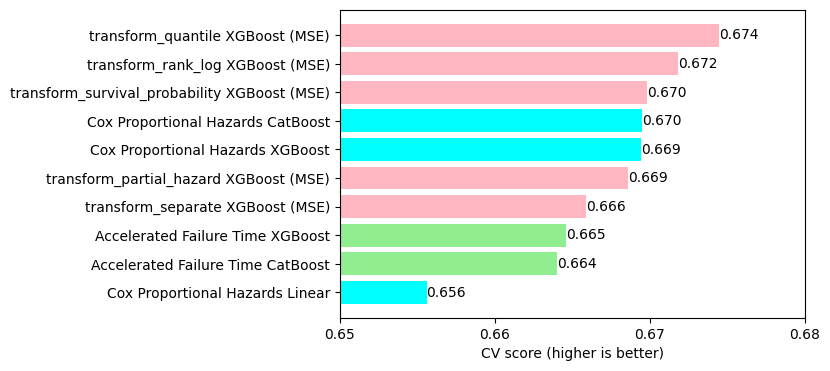

In [30]:
result_df = pd.DataFrame(all_model_scores, index=['score']).T
result_df = result_df.sort_values('score', ascending=False)
# with pd.option_context("display.precision", 3): display(result_df)
plt.figure(figsize=(6, len(result_df) * 0.4))

color = np.where(result_df.index.str.contains('Proportional'),
                 'cyan',
                 np.where(result_df.index.str.contains('Accelerated'), 'lightgreen', 
                          'lightpink'))
bars = plt.barh(np.arange(len(result_df)), result_df.score, color=color)
plt.gca().bar_label(bars, fmt='%.3f')
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlim(0.65, 0.68)
plt.xticks([0.65, 0.66, 0.67, 0.68])
plt.gca().invert_yaxis()
plt.xlabel('CV score (higher is better)')
plt.show()

### Feature importance
As `transform_quantile` was our best model,  
let's delve deeper into what features it cared about most:

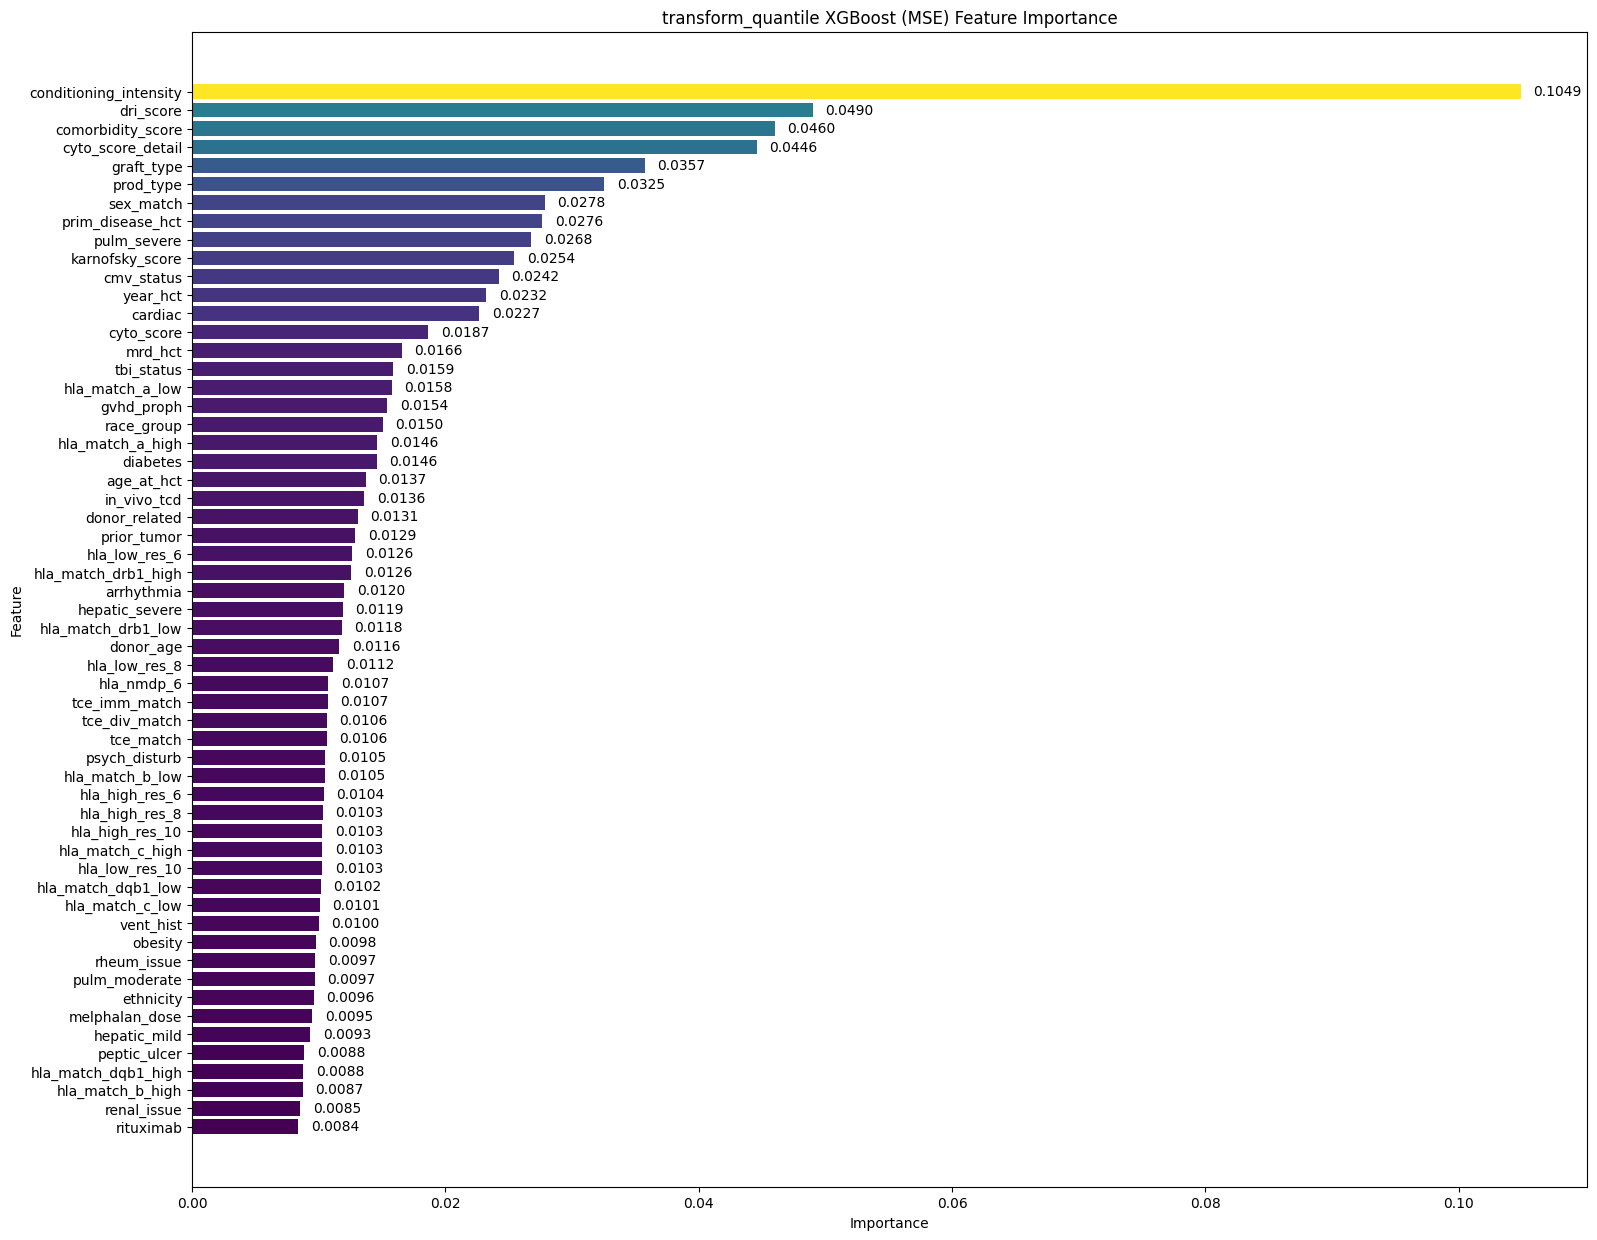

In [31]:
feature_importances = []

for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.race_group)):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = transform_quantile(time=train.iloc[idx_tr].efs_time, event=train.iloc[idx_tr].efs)

    model = xgboost.XGBRegressor(
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
    )
    model.fit(X_tr, y_tr)
    
    # Store feature importance
    feature_importances.append(model.feature_importances_)

# Convert to numpy array and compute mean importance
feature_importances = np.array(feature_importances)
mean_importance = feature_importances.mean(axis=0)

# Create DataFrame for mean feature importance
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": mean_importance
}).sort_values(by="Importance", ascending=False)

# Normalize importance values for colormap
norm = plt.Normalize(importance_df["Importance"].min(), importance_df["Importance"].max())
colors = plt.cm.viridis(norm(importance_df["Importance"]))

plt.figure(figsize=(18, 15))
bars = plt.barh(importance_df["Feature"], importance_df["Importance"], color=colors)

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("transform_quantile XGBoost (MSE) Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability

# Add labels to each bar
for bar in bars:
    plt.text(
        bar.get_width() + 0.001,  # Position the text slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center the text vertically
        f"{bar.get_width():.4f}",  # Format the value
        va="center",  # Align vertically
        ha="left",  # Align horizontally
        fontsize=10
    )

plt.show()

These results make a lot of sense!  
The `conditioning_intensity` describes how a patient's body was prepared for HCT.  
Other top features include various scores (`dri_score`, `comorbidity_score`, etc.) that are given to patients to determine their health before HCT.  
It fits that they contribute the most to the score as they reflect the physical state the patient was in before HCT.

### Race group inequality
With most models, the Asian predictions get the highest scores (best concordance index) and the predictions for white patients get the lowest scores (worst concordance). 

As the competition's objective (equitability across diverse patient populations) rewards models with similar concordance scores for all six race groups,  
a possible strategy could be to artificially make the predictions for Asian patients worse.  

### Working environment
As we heard many disrecommendations for Kaggle notebooks as a work environment, we immediately skipped that option.

First we tried Google collab, but it proved difficult to work in,  
as the platform has bad intellisense, and no real realtime abillities.

We decided to switch to a rather newer option, Deepnote.  
It was easier to work there, due to having built in intellisense, realtime collaboration, and pretty UI.  
But for some reason, they made it really hard to work with text/markdown blocks.

We ended up working locally in VSCode by setting up a virtual environment,  
and using the Live Share extension for realtime collaboration.  
It wasn't super hard to set up, and is pretty easy to work with.  
So in the future, we will start with this option.